# Notebook to test how to approach the short term persistence measurement using flt files as stimulus and ima files as the images where to measure persistence


In [1]:
from astropy.io import fits
import glob, os, shutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from scipy.special import gammaincc, gamma
from scipy.interpolate import interp1d
from astropy.wcs import WCS
from astropy.stats import histogram

%matplotlib notebook

In [2]:
# The project dir 
pdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/'

#Setup the working directory and change into it

wdir = pdir+'/14016_data/Visit01/'
os.chdir(wdir)

#The mosaic dir
mdir = pdir+'/Mosaic_hi_res_folder/'

In [3]:
#Single and double exponential models to be fitted to the data

def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def intdec1(t,a1,t1):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td)
    
def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2

def intdec2(t,a1,t1,a2,t2):
    tu = t[1:]
    td = t[:-1]
    k1,k2  = -a1*t1, - a2*t2
    
    return k1*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) + k2*(np.exp(-tu/t2)-np.exp(-td/t2))/(tu-td)

#Single exponential models plus a constant

def intdec1_plusconst(t,a1,t1,q):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) +q

def dec1_plusconst(t,a1,t1,q):
    e1 = a1*np.exp(-t/t1)
    return e1+q


#Shifted power law model

def shpwl(t,t0,A,index):
    return A * ((t+t0)/1000)**index
    
def intshpwl(t,t0,A,index):
    tu = t[1:]
    td = t[:-1]
        
    if (index == -1.):
        return A*np.log( (tu+t0)/(td+t0) )
    else:
        return A/(1+index) * ( ((tu+t0)/1000)**(1+index) - ((td+t0)/1000)**(1+index) )/(tu-td)
    
#A-gamma power law model

def AGpwl(t,A,index):
    return A * (t/1000)**index
    
def intAGpwl(t,A,index):
    tu = t[1:]
    td = t[:-1]
        
    if (index == -1.):
        return A*np.log( tu/td )
    else:
        return A/(1+index) * ( (tu/1000)**(1+index) - (td/1000)**(1+index) )/(tu-td)
    
    
#Schechter like model

def schechter(t,phi,alpha,tstar):
    x = t/tstar
    return phi*(x**alpha)*np.exp(-x)

def intschechter(t,phi,alpha,tstar):
    x = t/tstar

    tu = x[1:]
    td = x[:-1]

    g1 = gammaincc(alpha+1,td)
    g2 = gammaincc(alpha+1,tu)
    
    diff = gamma(alpha+1)*(g1-g2)
    
    return phi*diff

In [4]:
#Geometric median calculation function

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1, D

        y = y1



<IPython.core.display.Javascript object>


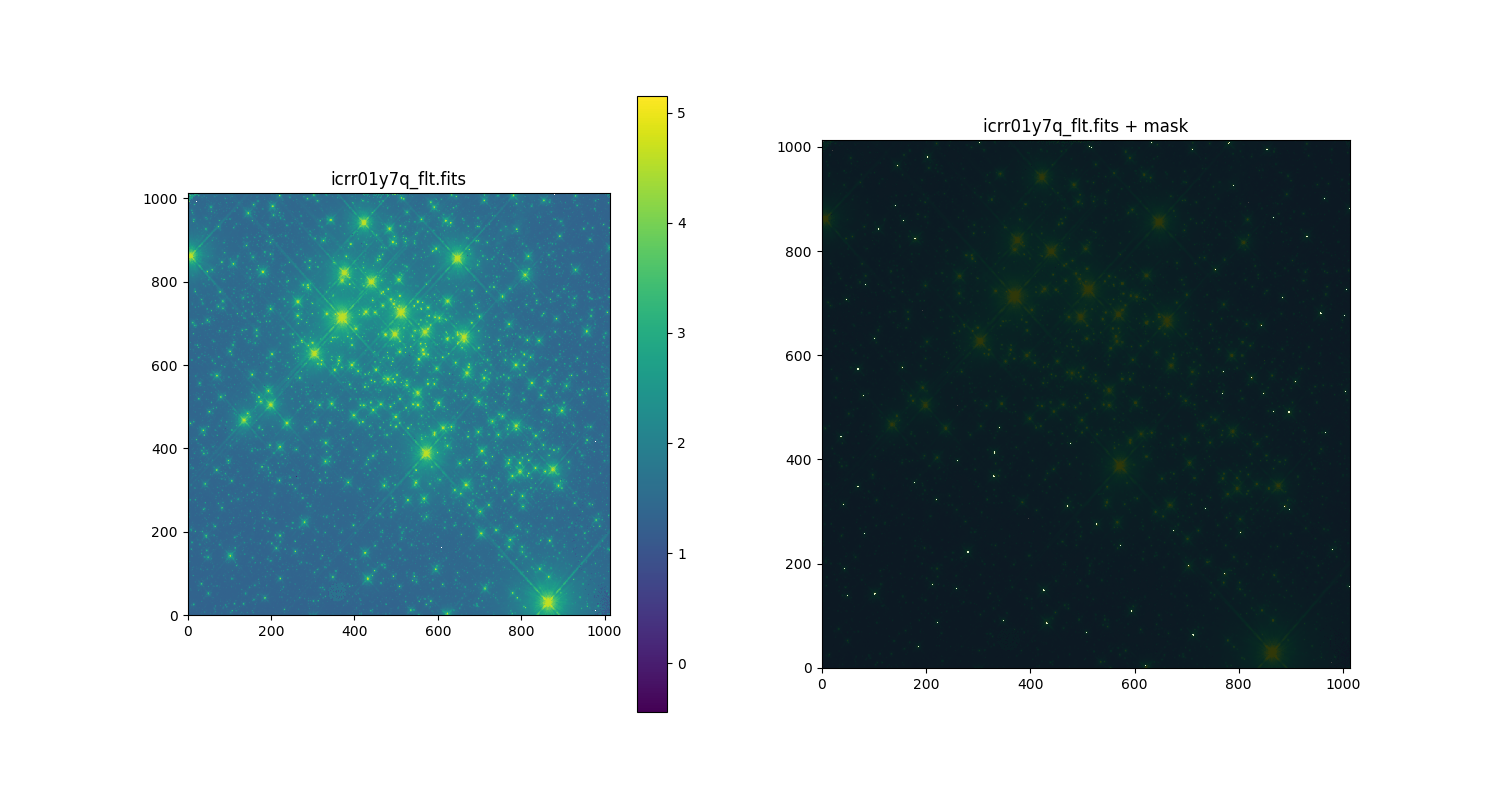

icrr01y7q_flt.fits F140W 21:32:57 0.0 0.0 352.939514 F140W
-15.6977


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in log10


In [5]:
# Print the exposure information for the stimulus image

sfltname = 'icrr01y7q_flt.fits'
pimaname = 'icrr01y8q_ima.fits'
pfltname = 'icrr01y8q_flt.fits'

sflt = fits.getdata(sfltname)
pflt = fits.getdata(pfltname)

fig = plt.figure(figsize=(15,8))

sfhdr0 = fits.getheader(sfltname,0)
sfhdr1 = fits.getheader(sfltname,1)

print(sfltname, sfhdr0['FILTER'], sfhdr0['TIME-OBS'], sfhdr0['POSTARG1'], sfhdr0['POSTARG2'], sfhdr0['EXPTIME'], sfhdr0['FILTER'])
    
ax1 = fig.add_subplot(1,2,1)
c, low, upp = sigmaclip(sflt, 2.5,3)
mn = np.amin(c)
print(mn)
im = ax1.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax1.set_title(sfltname)
fig.colorbar(im, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax2.set_title(sfltname+' + mask')




<IPython.core.display.Javascript object>


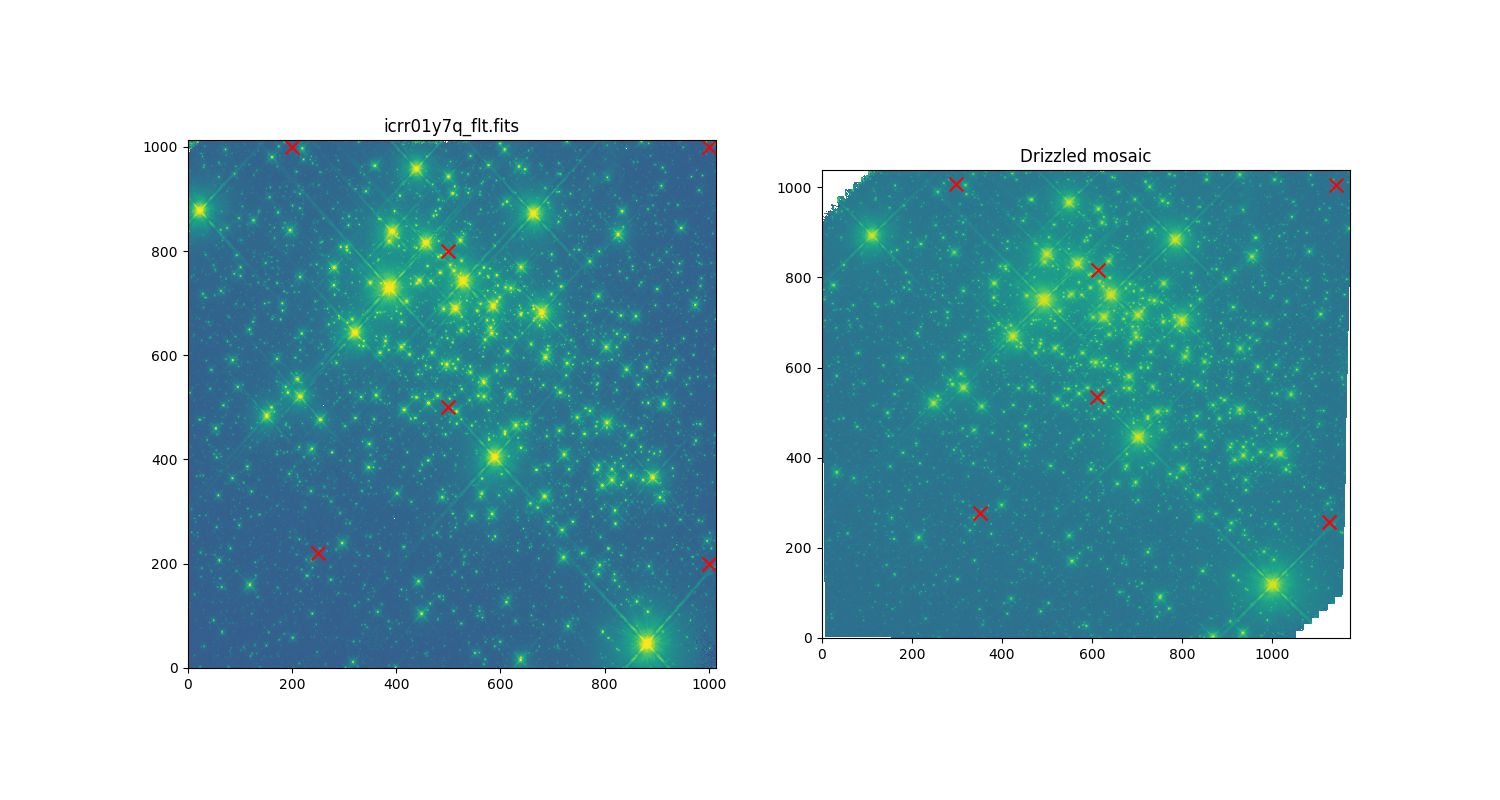

-16.9497


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


-15.3456


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log10


In [6]:
fig = plt.figure(figsize=(15,8))

ax0 = fig.add_subplot(1,2,1)
c, low, upp = sigmaclip(pflt, 2.5,3)
mn = np.amin(c)
print(mn)
im = ax0.imshow(np.log10(pflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax0.set_title(sfltname)


# Read the mosaic file and plot it

mosaic = fits.open(mdir+'/F140W_Mosaic_WFC3_IR_drz.fits')

ax1 = fig.add_subplot(1,2,2)
c, low, upp = sigmaclip(mosaic[1].data[np.where(np.isfinite(mosaic[1].data))], 2.5,3)
mn = np.amin(c)
print(mn)
im = ax1.imshow(np.log10(mosaic[1].data-mn),cmap='viridis', interpolation='none', origin='lower')
ax1.set_title('Drizzled mosaic')
#fig.colorbar(mosaic[1].data, ax=ax1)

#Create the wcs objects for the flt 


w_mosaic = WCS(mosaic[1].header)
w_stim   = WCS(fits.getheader(mdir+sfltname,1))
w_pers   = WCS(fits.getheader(mdir+pfltname,1))

#Verify trasformations

S_xy = np.array([[250,220],[500,500],[500,800],[1000,200],[200,1000],[1000,1000]])
P_xy = S_xy
M_xy = w_mosaic.all_world2pix(w_pers.all_pix2world(S_xy,0),0)

ax0.scatter(S_xy[:,0],S_xy[:,1],s=100,marker='x',c='r')
ax1.scatter(M_xy[:,0],M_xy[:,1],s=100,marker='x',c='r')

In [7]:
#Select the region in the stimulus image that will be looked at in the IMA image 

mode = 'lev'

msky = np.nanmean(sigmaclip(pflt,2.5,2.5)[0])
ssky = np.nanstd(sigmaclip(pflt,2.5,2.5)[0])

if (mode == 'cen'):
    xcen = 29
    ycen = 19
    rad = 2
    ix = np.arange(fhdr1['NAXIS1'])
    iy = np.arange(fhdr1['NAXIS2'])
    ixx,iyy = np.meshgrid(ix,iy)
    igood = (np.abs(ixx-xcen) < rad) & (np.abs(iyy-ycen) < rad)
elif (mode == 'lev'):
    lev_u = np.inf
    lev_d = 1e4
    igood = (sflt > lev_d) & (sflt < lev_u) & (pflt < msky+1*ssky) & (pflt > msky-1*ssky)

print('Number of selected pixels:',np.sum(igood))

#fig = plt.figure(figsize=(10,8))
#ax1 = fig.add_subplot(1,1,1)
ax2.imshow(igood,cmap='gray', interpolation='none',alpha=0.75,origin='lower')



Number of selected pixels: 410


In [8]:
#NSAMP

nsamp = fits.getheader(pfltname)['NSAMP']
pimahdu = fits.open(pimaname)
pflthdu = fits.open(pfltname)
sflthdu = fits.open(sfltname)

ramps  = np.zeros([np.sum(igood),nsamp-1])
eramps = np.zeros([np.sum(igood),nsamp-1])
rfits = np.zeros(np.sum(igood))
sfits = np.zeros(np.sum(igood))
mfits = np.zeros(np.sum(igood))
ffits = np.zeros(np.sum(igood))
dfits = np.zeros(np.sum(igood))
nsky  = np.zeros(np.sum(igood))
ncsky  = np.zeros(np.sum(igood))

nramps = np.sum(igood)
print('Number of ramps',np.sum(igood))

skyrad_o = 25
skyrad_i = 15

times = np.zeros(nsamp-1)
xgrid,ygrid = np.meshgrid( np.arange(pflthdu[1].data.shape[1]) ,np.arange(pflthdu[1].data.shape[0]))
dxgrid,dygrid = np.meshgrid( np.arange(mosaic[1].data.shape[1]) ,np.arange(mosaic[1].data.shape[0]))

drz_fin = np.isfinite(mosaic[1].data)
msky_d  = np.nanmean(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
ssky_d  = np.nanstd(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
mask_sky_contam = (mosaic[1].data <msky_d+3*ssky_d) & (mosaic[1].data >msky_d-3*ssky_d)


for i in range(nsamp-1):
    edt1 = pimahdu['ERR',i+1].data[5:-5,5:-5]
    edt2 = pimahdu['ERR',i+2].data[5:-5,5:-5]
    sdt1 = pimahdu['SCI',i+1].data[5:-5,5:-5]
    sdt2 = pimahdu['SCI',i+2].data[5:-5,5:-5]
    
    times[i] = pimahdu['TIME',i+1].header['PIXVALUE']
    t1 = times[i]
    t2 = pimahdu['TIME',i+2].header['PIXVALUE']
    tdenom = (t1-t2)
    
    eramps[:,i] = (1./tdenom)*np.sqrt(np.sum(np.square([t1*edt1[igood],t2*edt2[igood]]),axis=0)) 
    ramps[:,i]  = (sdt1[igood]*t1 -  sdt2[igood]*t2)/tdenom
    
toff = (pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'])*60*60*24
    
goodx = xgrid[igood]
goody = ygrid[igood]
    
for j in range(nramps):
    rfits[j] = pflthdu[1].data[igood][j]
    sfits[j] = sflthdu[1].data[igood][j]
    ix = goodx[j]
    iy = goody[j]

    #Fit the sky using neighboring pixels
    dst = np.sqrt((xgrid-ix)**2 + (ygrid-iy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
    skyarr = pflthdu[1].data[msk]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    mfits[j] = np.nanmean(cskyarr)
    nsky[j] = skyarr.size
    ncsky[j] = cskyarr.size
    
    #Fit the sky using an exponential + costant model
#   pars, cov = curve_fit(dec1_plusconst, times[::-1]+toff,ramps[j,::-1],p0=[4,100,30])
#   ffits[j] = pars[-1]
    
    #Get the sky from the drizzled image

    coords = w_mosaic.all_world2pix(w_pers.all_pix2world(np.array([[ix,iy]],dtype=np.float_),0),0) 
    dx = coords[0,0]
    dy = coords[0,1]
    
    
    dst2 = np.sqrt((dxgrid-dx)**2 + (dygrid-dy)**2)
    msk2 = (dst2<skyrad_o) & (dst2 > skyrad_i) & drz_fin & mask_sky_contam 
    skyarr = mosaic[1].data[msk2]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    dfits[j] = np.nanmean(cskyarr)

isort = np.argsort(sfits)[::-1]

sfits = sfits[isort]
rfits = rfits[isort]
mfits = mfits[isort]
ffits = ffits[isort]
dfits = dfits[isort]

ramps  = ramps[isort,:]
eramps = eramps[isort,:]

goodx  = goodx[isort]
goody  = goody[isort]

nsky  = nsky[isort]
ncsky  = ncsky[isort]



Number of ramps 410


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in less
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in greater


In [9]:
# Find out how much persistence knox's model would have predicted

import knox_stuff as kls

tima    = (np.append(times,0)+toff)[::-1]
klp     = np.zeros_like(ramps)
agmodel = kls.read_models_spv()

subint = 100

for j in range(len(tima)-1):
    ts = tima[j]
    te = tima[j+1]
    ti = np.linspace(ts, te, num=subint)  
    part_klp = np.zeros([nramps,subint])
    
    for i in range(subint):
        part_klp[:,i] = kls.make_persistence_image_spv(sfits*sfhdr0['EXPTIME'],agmodel,exptime=sfhdr0['EXPTIME'],dt=ti[i])
        #part_klp[:,i] = AGpwl(ti[i],0.3,-1.1)
    for k in range(nramps):
        klp[k,j] = np.trapz(part_klp[k,:],x=ti)

    klp[:,j] /= (te-ts)
        
klp = klp[:,::-1] 

<IPython.core.display.Javascript object>


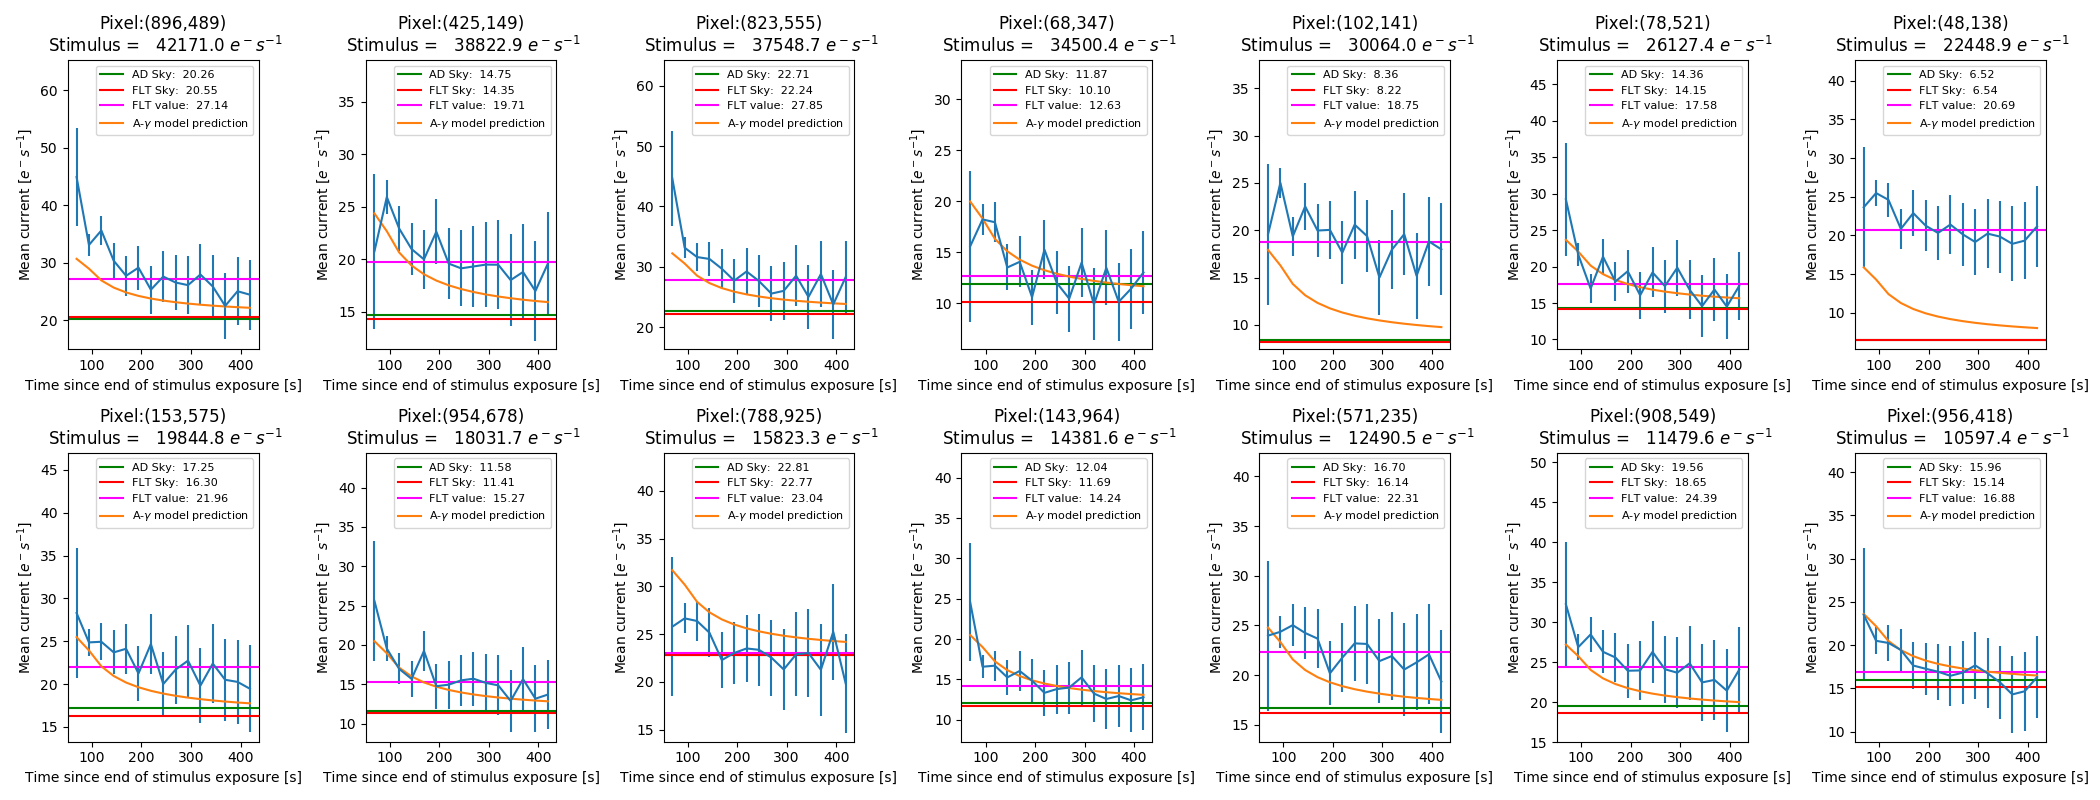

In [10]:
plot_every = 30
ppr = 7

nplots = (nramps+plot_every-1)//plot_every 
nrows  = (nplots+ppr-1)//ppr

fig    = plt.figure(figsize=(3.*ppr,4*nrows))
deltat = np.logspace(np.log10(times[0]+(pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'])*24*60*60),
                     np.log10(times[-1]+(pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'])*24*60*60),100)

ax = []
for j,aa in enumerate(range(0,nramps,plot_every)):
    ax.append(fig.add_subplot(nrows,ppr,j+1))

    ax[-1].errorbar(times+toff,ramps[aa,:],yerr=eramps[aa,:])
    ax[-1].axhline(dfits[aa],color='g',label='AD Sky: '+'% .2f' %dfits[aa])
    ax[-1].axhline(mfits[aa],color='r',label='FLT Sky: '+'% .2f' %mfits[aa])
    ax[-1].axhline(rfits[aa],color='magenta',label='FLT value: '+'% .2f' %rfits[aa])#

    ylim = ax[-1].get_ylim()
    ylim = list(ylim)
    ylim[1]+=10
    ylim=tuple(ylim)
    ax[-1].plot(times+toff,klp[aa,:]+mfits[aa],label='A-$\gamma$ model prediction')    

    ax[-1].legend(fontsize=8)
    ax[-1].set_title('Pixel:('+str(goodx[aa])+','+str(goody[aa])+')'+'\n Stimulus =  '+'% .1f' % sfits[aa] +' $ e^- s^{-1}$')
    ax[-1].set_ylim(ylim)

    ax[-1].set_xlabel('Time since end of stimulus exposure [s]')
    ax[-1].set_ylabel('Mean current [$ e^- s^{-1}$]')
    
    #    ax[-1].set_yscale('log')
#    ax[-1].set_xscale('log')
    
    
plt.tight_layout()

In [11]:
toff = (pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'])*60*60*24
#tmod   = np.linspace(times[0],times[-1],100)
#deltat = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'] + tmod

ufits = dfits

mnp = np.zeros(nsamp-1)
mdp = np.zeros(nsamp-1)
sdp = np.zeros(nsamp-1)

mnp_klp = np.zeros(nsamp-1)
mdp_klp = np.zeros(nsamp-1)
sdp_klp = np.zeros(nsamp-1)


for nn in range(nsamp-1):
    mnp[nn] = np.mean(ramps[:,nn]-ufits)
    mdp[nn] = np.median(ramps[:,nn]-ufits)    
    c,l,u = sigmaclip(ramps[:,nn]-ufits,2.,2.)
    sdp[nn] = np.nanstd(c)

    mnp_klp[nn] = np.mean(klp[:,nn])
    mdp_klp[nn] = np.median(klp[:,nn])    
    c,l,u = sigmaclip(klp[:,nn],2.,2.)
    sdp_klp[nn] = np.nanstd(c)


gmp, Dgm = geometric_median(ramps-ufits[:,None], eps=1e-5)  

#Get the 68% closest curvees
idsort = np.argsort(Dgm[:,0])[0:nramps*0.68]

for nn in range(nsamp-1):
    sdp[nn] = np.nanstd(ramps[idsort,nn]-ufits[idsort])
  

#gmp_klp = geometric_median(klp, eps=1e-5)    
    

#popt1_md, pcov1_md = curve_fit(decay1, times+toff,mdp,sigma=sdp,p0=[4,100])
#popt1_mn, pcov1_mn = curve_fit(decay1, times+toff,mnp,sigma=sdp,p0=[4,100])
#popt1_gm, pcov1_gm = curve_fit(decay1, times+toff,gmp,sigma=sdp,p0=[4,100])

popt1_md_i, pcov1_md_i = curve_fit(intdec1, np.append(times,0)+toff,mdp,sigma=sdp,p0=[4,100])
popt1_mn_i, pcov1_mn_i = curve_fit(intdec1, np.append(times,0)+toff,mnp,sigma=sdp,p0=[4,100])
popt1_gm_i, pcov1_gm_i = curve_fit(intdec1, np.append(times,0)+toff,gmp,sigma=sdp,p0=[4,100])

#popt2_md, pcov2_md = curve_fit(decay2, times+toff,mdp,sigma=sdp,p0=[4,100,2,10])
#popt2_mn, pcov2_mn = curve_fit(decay2, times+toff,mnp,sigma=sdp,p0=[4,100,2,10])
#popt2_gm, pcov2_gm = curve_fit(decay2, times+toff,gmp,sigma=sdp,p0=[4,100,2,10])

popt2_md_i, pcov2_md_i = curve_fit(intdec2, np.append(times,0)+toff,mdp,sigma=sdp,p0=[4,100,2,10])
popt2_mn_i, pcov2_mn_i = curve_fit(intdec2, np.append(times,0)+toff,mnp,sigma=sdp,p0=[4,100,2,10])
popt2_gm_i, pcov2_gm_i = curve_fit(intdec2, np.append(times,0)+toff,gmp,sigma=sdp,p0=[4,100,2,10])

poptAG_md_i, pcovAG_md_i = curve_fit(intAGpwl, np.append(times,0)+toff,mdp,sigma=sdp,p0=[100,-1.05])
poptAG_mn_i, pcovAG_mn_i = curve_fit(intAGpwl, np.append(times,0)+toff,mnp,sigma=sdp,p0=[100,-1.05])
poptAG_gm_i, pcovAG_gm_i = curve_fit(intAGpwl, np.append(times,0)+toff,gmp,sigma=sdp,p0=[100,-1.05])

poptSG_md_i, pcovSG_md_i = curve_fit(intshpwl, np.append(times,0)+toff,mdp,sigma=sdp,p0=[-1,100,-1.05])
poptSG_mn_i, pcovSG_mn_i = curve_fit(intshpwl, np.append(times,0)+toff,mnp,sigma=sdp,p0=[-1,100,-1.05])
poptSG_gm_i, pcovSG_gm_i = curve_fit(intshpwl, np.append(times,0)+toff,gmp,sigma=sdp,p0=[-1,100,-1.05])

#poptSC_md_i, pcovSC_md_i = curve_fit(intschechter, np.append(times,0)+toff,mdp,sigma=sdp,p0=[10,2,100])
#poptSC_mn_i, pcovSC_mn_i = curve_fit(intschechter, np.append(times,0)+toff,mnp,sigma=sdp,p0=[10,2,100])
#poptSC_gm_i, pcovSC_gm_i = curve_fit(intschechter, np.append(times,0)+toff,gmp,sigma=sdp,p0=[10,2,100])


#print('*********')
#print('1 Exp decay')
#print(popt1_mn)
#print(popt1_md)
#print(popt1_gm)
print('*********')
print('1 Exp decay, integrated')
print(popt1_mn_i)
print(popt1_md_i)
print(popt1_gm_i)
#print('*********')
#print('2 Exp decay')
#print(popt2_mn)
#print(popt2_md)
#print(popt2_gm)
print('*********')
print('2 Exp decay integrated')
print(popt2_mn_i)
print(popt2_md_i)
print(popt2_gm_i)
print('*********')
print('Shifted power law decay integrated')
print(poptSG_mn_i)
print(poptSG_md_i)
print(poptSG_gm_i)
print('*********')
print('Power law decay integrated')
print(poptAG_mn_i)
print(poptAG_md_i)
print(poptAG_gm_i)
#print('*********')
#print('Schechter decay integrated')
#print(poptSC_mn_i)
#print(poptSC_md_i)
#print(poptSC_gm_i)


*********
1 Exp decay, integrated
[   9.75049251  254.72418031]
[   9.75738791  228.93763261]
[   9.66208967  237.27147366]
*********
2 Exp decay integrated
[   5.17844752  558.36841992   16.51981533   52.46206749]
[   5.00418595  489.88361922   19.438689     47.56947827]
[   5.15282069  489.49555728   17.98918987   48.6036336 ]
*********
Shifted power law decay integrated
[ -2.35545020e+01   1.40021255e+03  -6.08729218e-01]
[ -2.82476079e+01   1.18907328e+03  -6.36673963e-01]
[ -2.36095495e+01   1.22504974e+03  -6.44374818e-01]
*********
Power law decay integrated
[  1.26201377e+03  -7.28407337e-01]
[  1.02775418e+03  -7.97435234e-01]
[  1.09418911e+03  -7.72818253e-01]


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in power


<IPython.core.display.Javascript object>


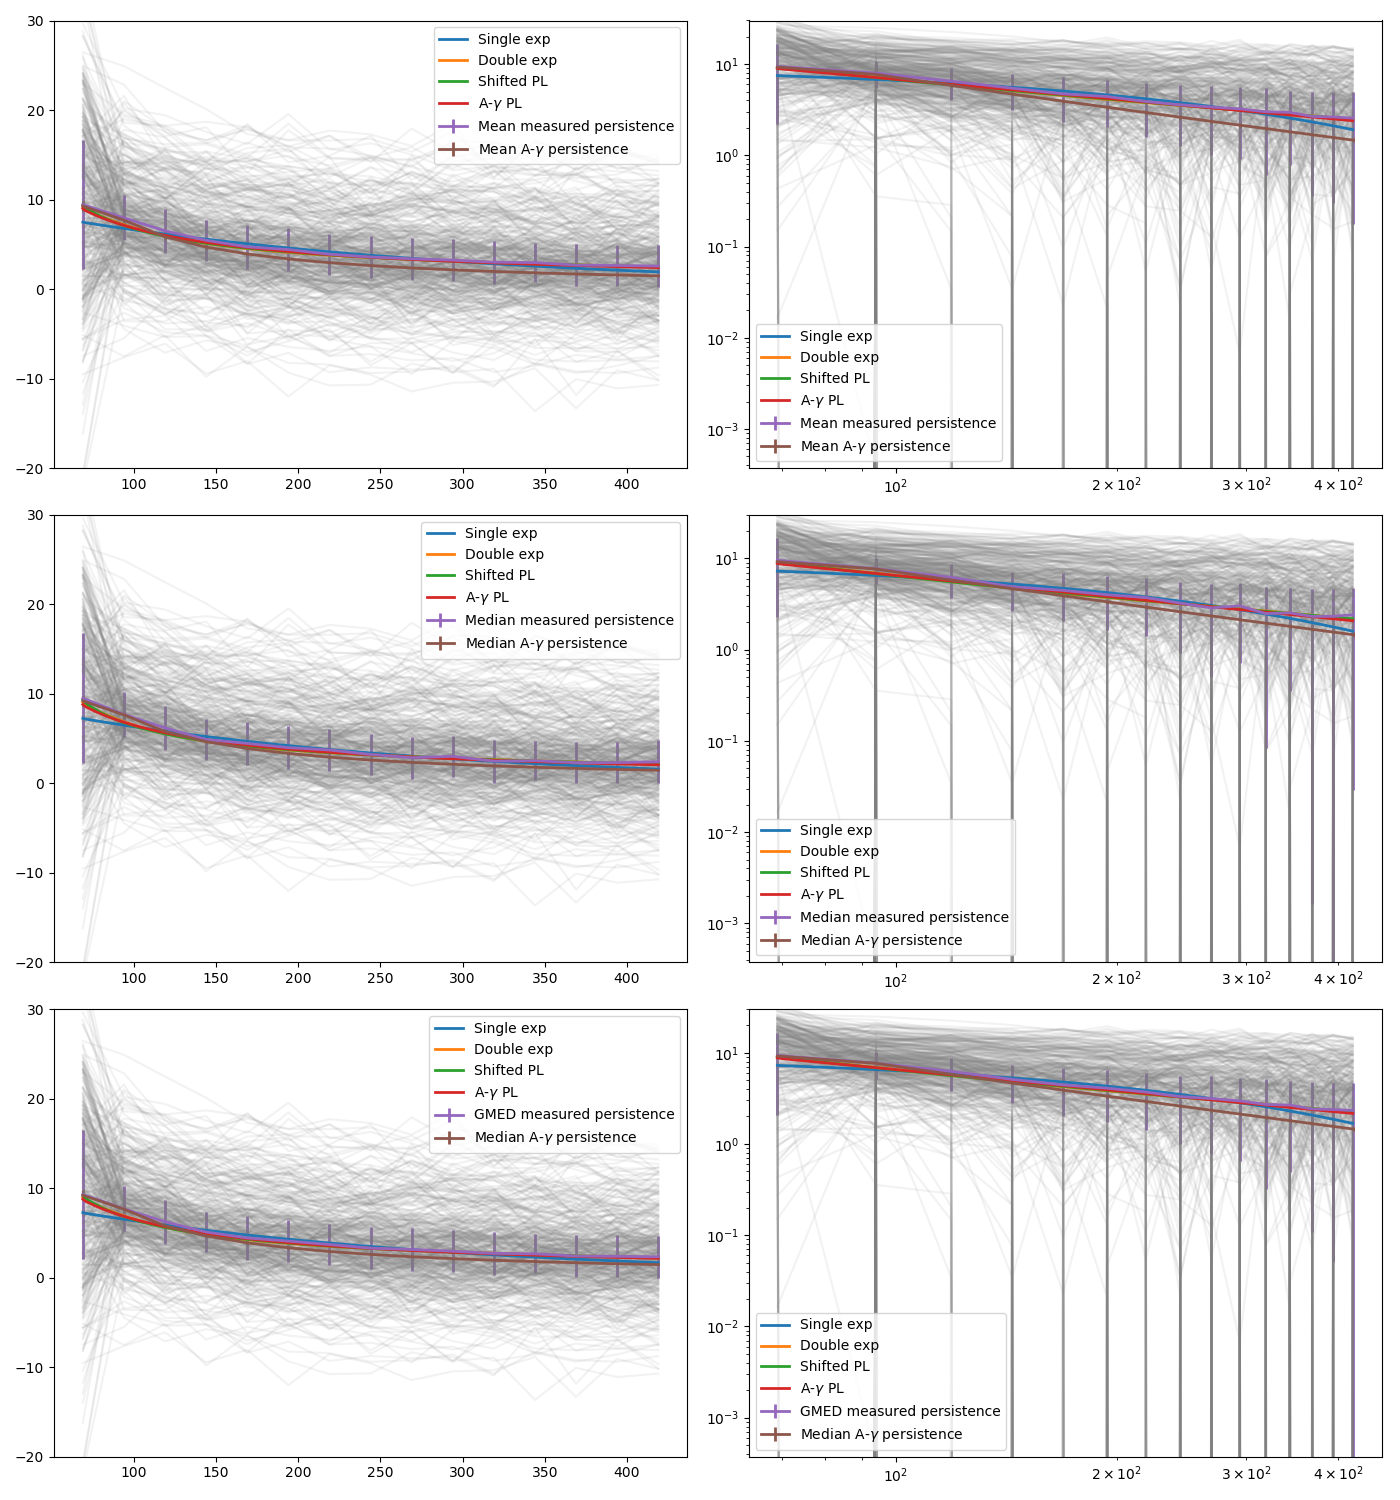

In [12]:
fig = plt.figure(figsize=(14,15))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)


deltat   = np.logspace(np.log10(times[0]+toff),np.log10(times[-1]+toff),100)

for aa in range(nramps):

    ax1.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax2.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax3.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax4.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax5.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax6.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)

    

#ax1.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
#ax2.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
#ax3.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)
#ax4.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)

ax1.plot(deltat,intdec1(np.append(deltat,toff),*popt1_mn_i),linewidth=2,label='Single exp')
ax2.plot(deltat,intdec1(np.append(deltat,toff),*popt1_mn_i),linewidth=2,label='Single exp')
ax3.plot(deltat,intdec1(np.append(deltat,toff),*popt1_md_i),linewidth=2,label='Single exp')
ax4.plot(deltat,intdec1(np.append(deltat,toff),*popt1_md_i),linewidth=2,label='Single exp')
ax5.plot(deltat,intdec1(np.append(deltat,toff),*popt1_gm_i),linewidth=2,label='Single exp')
ax6.plot(deltat,intdec1(np.append(deltat,toff),*popt1_gm_i),linewidth=2,label='Single exp')

#ax1.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
#ax2.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
#ax3.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)
#ax4.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)

ax1.plot(deltat,intdec2(np.append(deltat,toff),*popt2_mn_i),linewidth=2,label='Double exp')
ax2.plot(deltat,intdec2(np.append(deltat,toff),*popt2_mn_i),linewidth=2,label='Double exp')
ax3.plot(deltat,intdec2(np.append(deltat,toff),*popt2_md_i),linewidth=2,label='Double exp')
ax4.plot(deltat,intdec2(np.append(deltat,toff),*popt2_md_i),linewidth=2,label='Double exp')
ax5.plot(deltat,intdec2(np.append(deltat,toff),*popt2_gm_i),linewidth=2,label='Double exp')
ax6.plot(deltat,intdec2(np.append(deltat,toff),*popt2_gm_i),linewidth=2,label='Double exp')

ax1.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_mn_i),linewidth=2,label='Shifted PL')
ax2.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_mn_i),linewidth=2,label='Shifted PL')
ax3.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_md_i),linewidth=2,label='Shifted PL')
ax4.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_md_i),linewidth=2,label='Shifted PL')
ax5.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_gm_i),linewidth=2,label='Shifted PL')
ax6.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_gm_i),linewidth=2,label='Shifted PL')

#ax1.plot(deltat,intschechter(np.append(deltat,toff),*poptSC_mn_i),linewidth=2,label='Schechter')
#ax2.plot(deltat,intschechter(np.append(deltat,toff),*poptSC_mn_i),linewidth=2,label='Schechter')
#ax3.plot(deltat,intschechter(np.append(deltat,toff),*poptSC_md_i),linewidth=2,label='Schechter')
#ax4.plot(deltat,intschechter(np.append(deltat,toff),*poptSC_md_i),linewidth=2,label='Schechter')
#ax5.plot(deltat,intschechter(np.append(deltat,toff),*poptSC_gm_i),linewidth=2,label='Schechter')
#ax6.plot(deltat,intschechter(np.append(deltat,toff),*poptSC_gm_i),linewidth=2,label='Schechter')

ax1.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_mn_i),linewidth=2,label='A-$\gamma$ PL')
ax2.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_mn_i),linewidth=2,label='A-$\gamma$ PL')
ax3.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_md_i),linewidth=2,label='A-$\gamma$ PL')
ax4.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_md_i),linewidth=2,label='A-$\gamma$ PL')
ax5.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_gm_i),linewidth=2,label='A-$\gamma$ PL')
ax6.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_gm_i),linewidth=2,label='A-$\gamma$ PL')


ax1.errorbar(times+toff,mnp,yerr=sdp,linewidth=2,label='Mean measured persistence')
ax2.errorbar(times+toff,mnp,yerr=sdp,linewidth=2,label='Mean measured persistence')
ax3.errorbar(times+toff,mdp,yerr=sdp,linewidth=2,label='Median measured persistence')
ax4.errorbar(times+toff,mdp,yerr=sdp,linewidth=2,label='Median measured persistence')
ax5.errorbar(times+toff,gmp,yerr=sdp,linewidth=2,label='GMED measured persistence')
ax6.errorbar(times+toff,gmp,yerr=sdp,linewidth=2,label='GMED measured persistence')

ax1.errorbar(times+toff,mnp_klp,yerr=sdp_klp,linewidth=2,label='Mean A-$\gamma$ persistence')
ax2.errorbar(times+toff,mnp_klp,yerr=sdp_klp,linewidth=2,label='Mean A-$\gamma$ persistence')
ax3.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax4.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax5.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax6.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')

    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xscale('log')

ax1.set_ylim(-20,30)
ax2.set_ylim(-20,30)
ax3.set_ylim(-20,30)
ax4.set_ylim(-20,30)
ax5.set_ylim(-20,30)
ax6.set_ylim(-20,30)
    
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
    
plt.tight_layout()

<IPython.core.display.Javascript object>


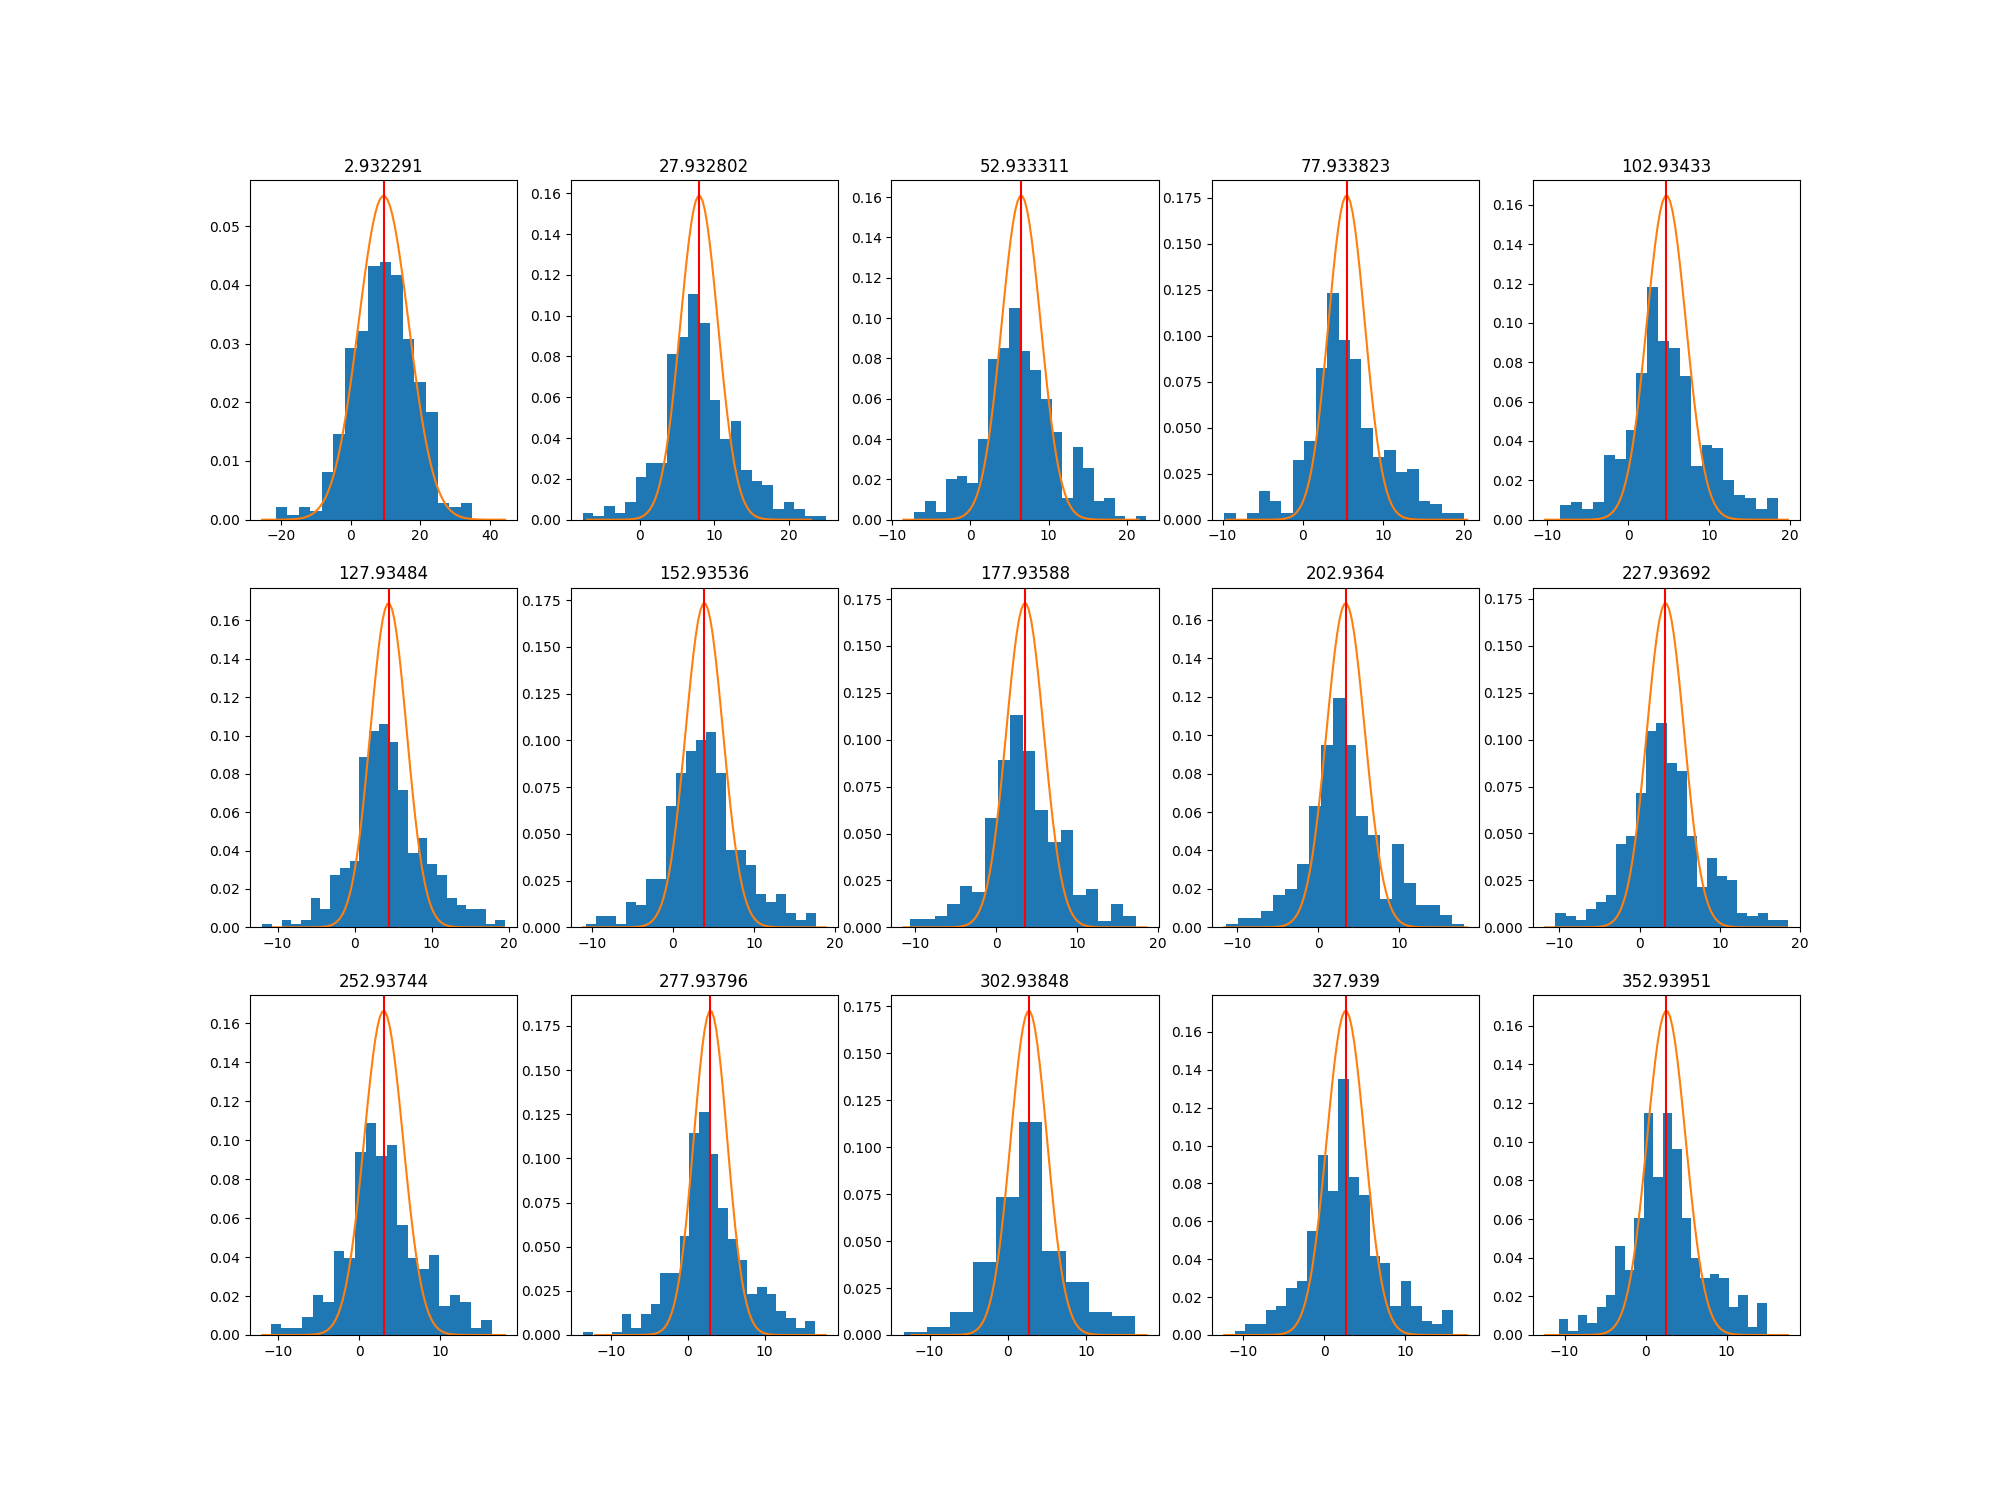

In [13]:
fig = plt.figure(figsize=(20,15))
ax = []

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi)) *np.exp(-0.5 * np.square( (x - mu)/sig))


from astropy.visualization import hist as aphist

import matplotlib.patches as patches

for j,tt in enumerate(times):
    
    ax.append(fig.add_subplot(3,5,len(times)-j))

    nn, bins, patches = aphist(ramps[:,j]-ufits,ax=ax[-1],normed=True,bins='knuth')
    
    if j == (len(times)-1):
        bins = np.linspace(-35+mnp[j],35+mnp[j],11)
    else:
        bins = np.linspace(-15+mnp[j],15+mnp[j],11)
        
    x = np.linspace(bins[0],bins[-1],100)
    g = gaussian(x,mnp[j],sdp[j])

    ax[-1].plot(x,g)    
    ax[-1].axvline(mnp[j],c='r')
    ax[-1].set_title(tt)


<IPython.core.display.Javascript object>


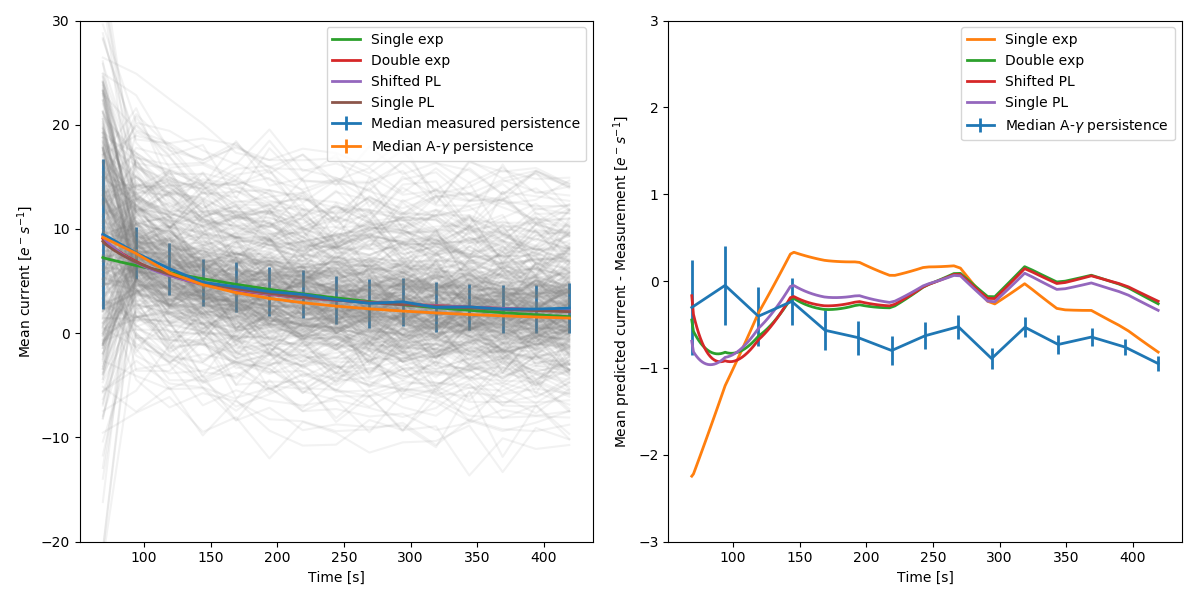

In [14]:
deltat   = np.logspace(np.log10(times[0]+toff),np.log10(times[-1]+toff),100)
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
for aa in range(nramps):

    ii = ramps[aa,:]-ufits[aa] > 0    
    ax1.plot(times+toff,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)


ax1.errorbar(times+toff,mdp,yerr=sdp,linewidth=2,label='Median measured persistence')
ax1.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax1.plot(deltat,intdec1(np.append(deltat,toff),*popt1_md_i),linewidth=2,label='Single exp')
ax1.plot(deltat,intdec2(np.append(deltat,toff),*popt2_md_i),linewidth=2,label='Double exp')
ax1.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_md_i),linewidth=2,label='Shifted PL')
ax1.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_md_i),linewidth=2,label='Single PL')

ax1.set_ylim(-20,30)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Mean current [$ e^- s^{-1}$]')
ax1.legend()


mdp_int = interp1d(times+toff,mdp,fill_value='extrapolate')

ax2 = fig.add_subplot(1,2,2)
#ax2.plot(times+toff,mdp-mdp,yerr=sdp,linewidth=2,label='Median measured persistence')
ax2.errorbar(times+toff,mdp_klp-mdp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax2.plot(deltat,intdec1(np.append(deltat,toff),*popt1_md_i)-mdp_int(deltat),linewidth=2,label='Single exp')
ax2.plot(deltat,intdec2(np.append(deltat,toff),*popt2_md_i)-mdp_int(deltat),linewidth=2,label='Double exp')
ax2.plot(deltat,intshpwl(np.append(deltat,toff),*poptSG_md_i)-mdp_int(deltat),linewidth=2,label='Shifted PL')
ax2.plot(deltat,intAGpwl(np.append(deltat,toff),*poptAG_md_i)-mdp_int(deltat),linewidth=2,label='Single PL')

ax2.set_ylim(-3,3)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Mean predicted current - Measurement [$ e^- s^{-1}$] ')

ax2.legend()

plt.tight_layout()
